# CNN with Bidirctional RNN - Char Classification
Using TensorFlow

## TODO
```
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import tensorflow.contrib.seq2seq as seq2seq
import cv2


%matplotlib notebook
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)


# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet
from ocr.imgtransform import coordinates_remap
from ocr.datahelpers import loadWordsData, correspondingShuffle
from ocr.tfhelpers import Graph, create_cell

tf.reset_default_graph()
sess = tf.InteractiveSession()

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.3.0


## Loading Images

In [2]:
images, _, gaplines = loadWordsData(['data/words/'],
                                    loadGaplines=True)


Loading words...
-> Number of words: 1008


## Settings

In [3]:
PAD = 0                            # Value for PADding images
POS = 1                            # Values of positive and negative label 0/-1
NEG = 0

POS_SPAN = 1                       # Number of positive values around true position (5 is too high)
POS_WEIGHT = 10                    # Weighting possitive values in loss counting

slider_size = (60, 30)             # Height is set to 60 by data and width should be even
slider_step = 2                    # Number of pixels slider moving
N_INPUT = 1800                     # Size of sequence input vector will depend on CNN
num_buckets = 10
n_classes = 2                      # Number of different outputs

rnn_layers = 4                     # 4 - 2 - 256
rnn_residual_layers = 2            # HAVE TO be smaller than encoder_layers
rnn_units = 128
attention_size = 64

learning_rate = 1e-4               # 1e-4
dropout = 0.4                      # Percentage of dopped out data
train_set = 0.8                    # Percentage of training data

TRAIN_STEPS = 500000                 # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 32
# EPOCH = 2000                       # "Number" of batches in epoch

## Dataset

In [4]:
# Shuffle data
images, gaplines = correspondingShuffle([images, gaplines])

for i in range(len(images)):
    # Add border and offset gaplines - RUN ONLY ONCE
    images[i] = cv2.copyMakeBorder(images[i],
                                   0, 0, int(slider_size[1]/2), int(slider_size[1]/2),
                                   cv2.BORDER_CONSTANT,
                                   value=0)
    gaplines[i] += int(slider_size[1] / 2)
    
# Image standardization same as tf.image.per_image_standardization
for i in range(len(images)):
    images[i] = (images[i] - np.mean(images[i])) / max(np.std(images[i]), 1.0/math.sqrt(images[i].size))

    
# Split data on train and test dataset
div = int(train_set * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainGaplines = gaplines[0:div]
testGaplines = gaplines[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

Training images: 806
Testing images: 202


In [5]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 gaplines,
                 gap_span,
                 num_buckets=5,
                 slider=(60, 30),
                 slider_step=2,
                 imgprocess=lambda x: x,
                 train=True):
        
        self.train = train
#         self.slider = slider
#         self.slider_step = slider_step
        length = [(image.shape[1]-slider[1])//slider_step for image in images]
    
        # Creating indices from gaplines
        indices = gaplines - int(slider[1]/2)
        indices = indices // slider_step
        
        # Split images to sequence of vectors
        # + targets seq of labels per image in images seq
        images_seq = np.empty(len(images), dtype=object)
        targets_seq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            images_seq[i] = [imgprocess(img[:, loc * slider_step: loc * slider_step + slider[1]].flatten())
                             for loc in range(length[i])]
            
            targets_seq[i] = np.ones((length[i])) * NEG
            for offset in range(gap_span):
                ind = indices[i] + (-(offset % 2) * offset // 2) + ((1 - offset%2) * offset // 2) 
                
                if ind[0] < 0:
                    ind[0] = 0
                if ind[-1] >= length[i]:
                    ind[-1] = length[i] - 1
                    
                targets_seq[i][ind] = POS
                

        # Create pandas dataFrame and sort it by images seq lenght (length) 
        # in_length == out_length
        self.dataFrame = pd.DataFrame({'length': length,
                                       'images': images_seq,
                                       'targets': targets_seq
                                      }).sort_values('length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")


    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        max_length = max(res['length'])
        
        input_seq = np.zeros((batch_size, max_length, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)
        
        # Need to pad according to the maximum length output sequence
        targets = np.ones([batch_size, max_length], dtype=np.float32) * PAD
        for i, target in enumerate(targets):
            target[:res['length'].values[i]] = res['targets'].values[i]
        
        return input_seq, targets, res['length'].values


    def next_feed(self, size):
        """ Create feed directly for model training """
        (inputs_,
         targets_,
         length_) = self.next_batch(size)
        return {
            inputs: inputs_,            
            targets: targets_,
            length: length_,
            keep_prob: (1.0 - dropout) if self.train else 1.0
        }

In [6]:
# Create iterator for feeding BiRNN
train_iterator = BucketDataIterator(trainImages,
                                    trainGaplines,
                                    POS_SPAN,
                                    num_buckets,
                                    slider_size,
                                    slider_step,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testGaplines,
                                   POS_SPAN,
                                   2,
                                   slider_size,
                                   slider_step,
                                   train=False)

Iterator created.
Iterator created.


# Create classifier

## Inputs

In [7]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Inputs shape (max_seq_length, batch_size, vec_size) - time major
inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='inputs')
length = tf.placeholder(shape=(None,),
                        dtype=tf.int32,   # EDITED: tf.int32
                        name='length')
# required for training, not required for testing and application
targets = tf.placeholder(shape=(None, None),
                         dtype=tf.int64,
                         name='targets')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

sequence_size, batch_size, _ = tf.unstack(tf.shape(inputs))

## Standardization + CNN

In [8]:
# Help functions for standard layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

# 1. Layer - Convulation variables
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, 4],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[4]), name='b_conv1')
# 3. Layer - Convulation variables
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 4, 8],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[8]), name='b_conv2')

def CNN(x):
    # 1. Layer - Convulation
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name='h_conv1')
    # 2. Layer - Max Pool
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    # 3. Layer - Convulation
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')
    # 4. Layer - Max Pool
    return max_pool_2x2(h_conv2, name='h_pool2')

# Input images CNN
inpts = tf.map_fn(
    lambda seq: tf.map_fn(
        lambda img:
            tf.reshape(
                CNN(tf.reshape(img, [1, slider_size[0], slider_size[1], 1])), [-1]),
        seq),
    inputs,
    dtype=tf.float32)

### Attention

In [9]:
# attention_states: size [batch_size, max_time, num_units]
attention_states = tf.transpose(inpts, [1, 0, 2])

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    rnn_units, attention_states,
    memory_sequence_length=length)


final_cell = create_cell(rnn_units,
                         2*rnn_layers,
                         2*rnn_residual_layers,
                         is_dropout=True,
                         keep_prob=keep_prob)

final_cell = seq2seq.AttentionWrapper(
    final_cell, attention_mechanism,
    attention_layer_size=attention_size)

final_initial_state = final_cell.zero_state(batch_size, tf.float32)


attention_output, _ = tf.nn.dynamic_rnn(
    cell=final_cell,
    inputs=attention_states,
    sequence_length=length,
#     initial_state=final_initial_state,
    dtype = tf.float32)

In [10]:
pred = tf.layers.dense(inputs=attention_output,
                       units=2,
                       name='pred')
prediction = tf.argmax(pred, axis=-1, name='prediction')

## Optimizer

In [11]:
# Define loss and optimizer
# loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=targets), name='loss')
weights = tf.multiply(targets, POS_WEIGHT) + 1
loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(
    logits=pred,
    labels=targets,
    weights=weights), name='loss')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, name='train_step')

# Evaluate model
correct_pred = tf.equal(prediction, targets)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# accuracy = tf.reduce_mean(prediction * targets)  # Testing for only zero predictions

## Training

<IPython.core.display.Javascript object>


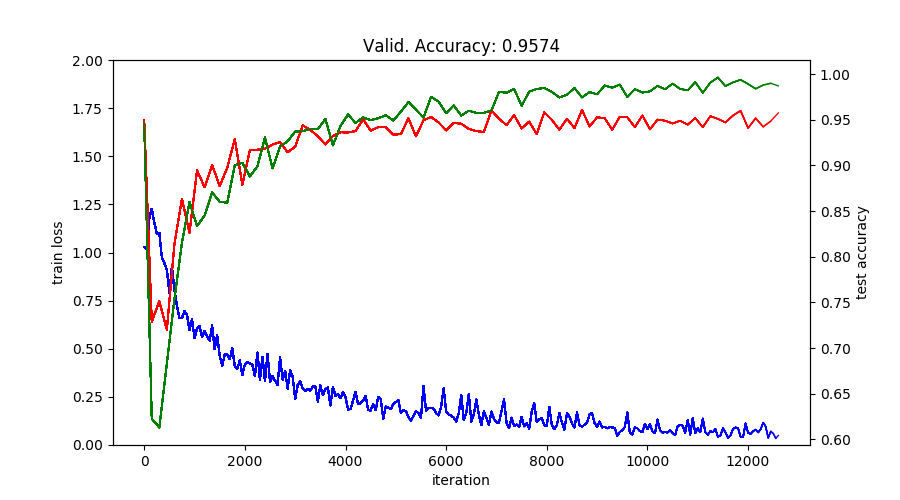

Training interrupted, model saved.
Training finished with accuracy: 0.954117


In [12]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, 'models/gap-clas/A-RNN/model')
        
#         if i_batch % EPOCH == 0:
#             fd_test = test_iterator.next_feed(BATCH_SIZE)
#             print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
#             predict_, target_ = sess.run([pred, targets], fd_test)
#             for i, (inp, pred) in enumerate(zip(target_, predict_)):
#                 print('    expected  > {}'.format(inp))
#                 print('    predicted > {}'.format(pred))
#                 break
#             print()

except KeyboardInterrupt:
    saver.save(sess, 'models/gap-clas/A-RNN/model')
    print('Training interrupted, model saved.')


fd_test = test_iterator.next_feed(2*BATCH_SIZE)
accTest = accuracy.eval(fd_test)
print("Training finished with accuracy:", accTest)

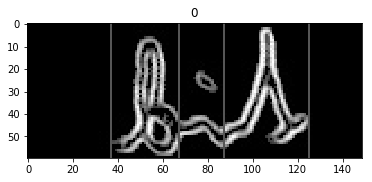

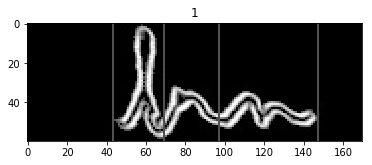

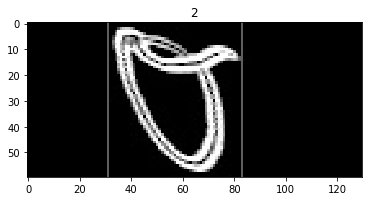

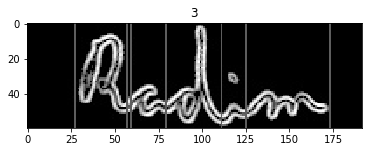

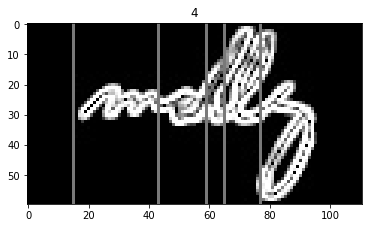

In [26]:
% matplotlib inline

num_examples = 5

# Shuffle test images
testImages = testImages[np.random.permutation(len(testImages))]
imgs = testImages[:num_examples]

# Split images to sequence of vectors
length = [(image.shape[1]-slider_size[1])//slider_step for image in imgs]
images_seq = np.empty(num_examples, dtype=object)
for i, img in enumerate(imgs):
    images_seq[i] = np.array([img[:, loc * slider_step: loc * slider_step + slider_size[1]].flatten()
                              for loc in range(length[i])], dtype=np.float32)

# Create predictions using trained model
test_pred = []
for i, inpt in enumerate(images_seq):
    inpt = np.reshape(inpt, (inpt.shape[0], 1, inpt.shape[1]))
    img = imgs[i].copy()
#     img = cv2.cvtColor(imgs[i].astype(np.float32), cv2.COLOR_GRAY2RGB)
    pred = prediction.eval({'inputs:0': inpt,
                            'length:0': [len(inpt)],
                            'keep_prob:0': 1.0})
    for pos, g in enumerate(pred[0]):
        if g == 1:
            cv2.line(img,
                     ((int)(15 + pos*slider_step), 0),
                     ((int)(15 + pos*slider_step), slider_size[0]),
                     1, 1)
        
    implt(img, 'gray', t=str(i))